1. **Problem Definition**
- Our goal was to classify between fainted, sleep and awake images of people.
- *Lables are:*
    1. fainted
    2. ⁠sleeping
    3. ⁠awake
- *Motivation:*
    This project aims to develop an image-based classifier capable of identifying whether a person in an image is awake, sleeping, or fainted. The motivation behind this work is to support continuous monitoring of individuals who may require medical supervision throughout the day, such as elderly people or patients at risk of sudden loss of consciousness. By automatically detecting potentially dangerous states like fainting, the system could enable faster response times and timely intervention, thereby improving safety and quality of care while reducing the need for constant human observation
    - Expected challenges:
    1. Visual similarity between sleeping and fainted states makes classification difficult.
    2. Variations in lighting, camera angles, and image quality affect model performance.
    3. Differences in body posture, clothing, and individual appearance introduce noise.
    4. Limited or imbalanced datasets can bias the classifier toward common classes.
    5. Lack of temporal context in single images makes it harder to distinguish transient states like fainting.

2. **Dataset Creation and Preparation**
- We initiated a search for training data. On data science platforms such as Kaggle and Roboflow, we encountered datasets with similar classes, though none addressed our specific objective.
- After aggregating a sufficient number of images from Fall Detection and Sleep Pose datasets, we proceeded to the    data curation phase. This involved filtering out images   that could introduce 'noise' to the model, thereby        refining and improving the precision of our training      classes.
- For example, we extracted images from a fainting ward of people with their eyes open but who appear to be fainting or fainting people with their feet off the ground.
-*Dataset structure:*

    ├───test
    │ ├───awake
    │ ├───fainted
    │ └───sleeping
    └───train                                              ├───awake                                           ├───fainted                                         └───sleeping







In [23]:
from fastai.vision.all import *

path = Path("data/train")

3. **Data Loading**


In [5]:
# 1. Verify and remove corrupted images
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
if failed:
    print(f"The number of the images that that invalid: {len(failed)}")
else:
    print("All images are valid.")

All images are valid.


In [10]:
# 2. Create DataLoaders
dls = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
).dataloaders(path)

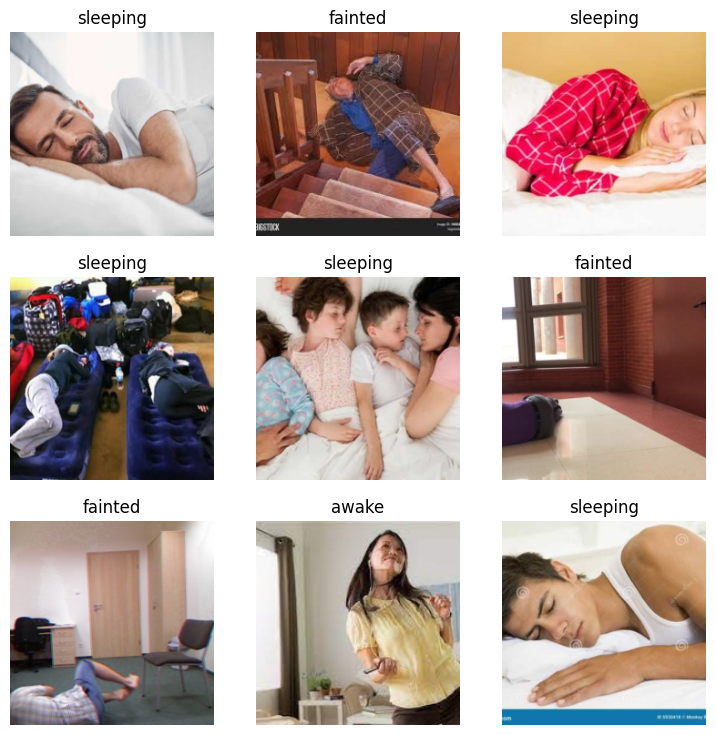

In [11]:
dls.show_batch(max_n=9)

4. **Model Training**

In [24]:
# 3. Create and train the model
epochs = 3 # More than 3 epochs caused overfitting
learn = vision_learner(dls, resnet34,
                       metrics=[error_rate, accuracy, Precision(average='macro'), Recall(average='macro')])
# learn.lr_find()
learn.fine_tune(epochs)

epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,1.588464,0.517638,0.202128,0.797872,0.801373,0.788924,00:57


epoch,train_loss,valid_loss,error_rate,accuracy,precision_score,recall_score,time
0,0.578294,0.256307,0.085106,0.914894,0.910710,0.909065,01:12
1,0.438192,0.148321,0.053191,0.946809,0.942012,0.946102,01:09
2,0.312790,0.146907,0.053191,0.946809,0.940705,0.940705,01:10


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

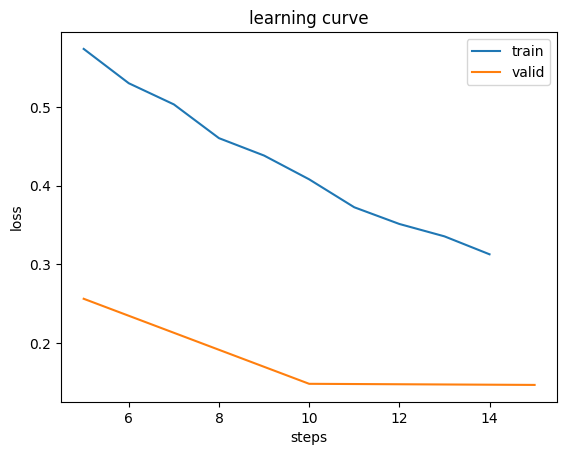

In [25]:
# learn.recorder.plot_loss() #### not finushed

Plotting metrics: ['valid_loss', 'error_rate', 'accuracy', 'precision_score', 'recall_score', 'time']


IndexError: list index out of range

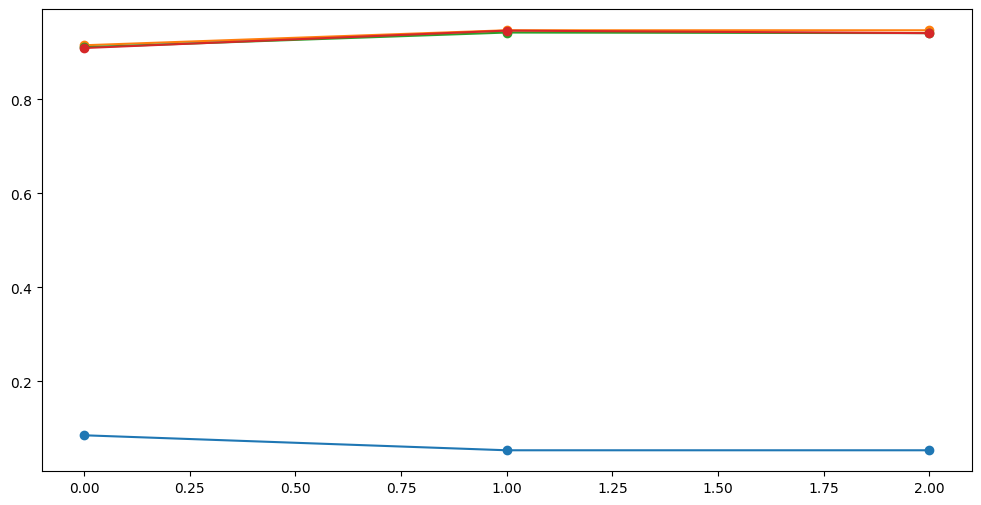

In [26]:
import matplotlib.pyplot as plt

# 1. שליפת שמות המדדים (למשל: valid_loss, accuracy, recall_score...)
# מדלגים על 'epoch' ו-'train_loss' שנמצאים בדרך כלל בהתחלה
metric_names = learn.recorder.metric_names[2:]
print(f"Plotting metrics: {metric_names}")

# 2. שליפת הערכים עצמם
# learn.recorder.values זו רשימה של רשימות (שורה לכל אפוק)
# אנחנו רוצים להפוך את זה כך שנקבל רשימה לכל מדד (Transposing)
values = list(zip(*learn.recorder.values))

# 3. יצירת הגרף
plt.figure(figsize=(12, 6))

# לולאה שעוברת על כל מדד ומוסיפה אותו לגרף
# הערכים מתחילים מאינדקס 2 כי 0 זה train_loss ו-1 זה valid_loss (בדרך כלל)
for i, metric_name in enumerate(metric_names):
    # values[i+2] מכיל את הנתונים של המדד הנוכחי לאורך האפוקים
    plt.plot(values[i+2], label=metric_name, marker='o')

plt.title('Metrics Change Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# Evaluate each image with the model (only for visualization)
# for image in Path("data/test").ls():
#     pred_class, pred_idx, probs = learn.predict(image)
#     print(f"Image: {image.name}, Predicted: {pred_class}, Probability: {probs[pred_idx]:.4f}, Real Class: {image.parent.name}")
#     break

Loss: 0.3968
Accuracy: 91.43%


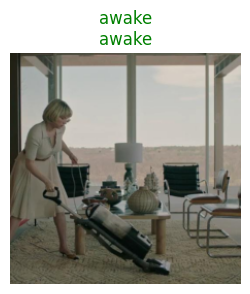

In [20]:
# 4. calculate accuracy on test set

test_path = Path('data/test')
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files, with_labels=True)
results = learn.validate(dl=test_dl)

print(f"Loss: {results[0]:.4f}")
print(f"Accuracy: {1 - results[1]:.2%}")   # לא נכון לבדוק שוב

learn.show_results(dl=test_dl, max_n=1)

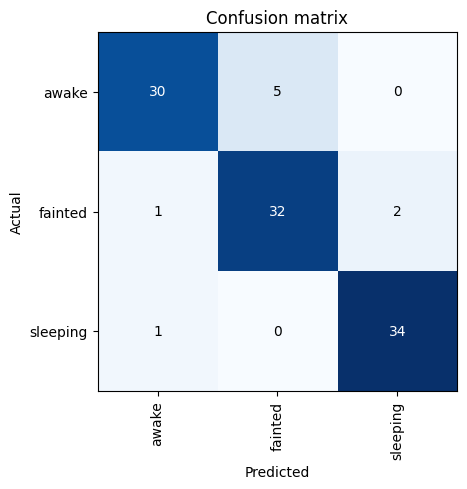

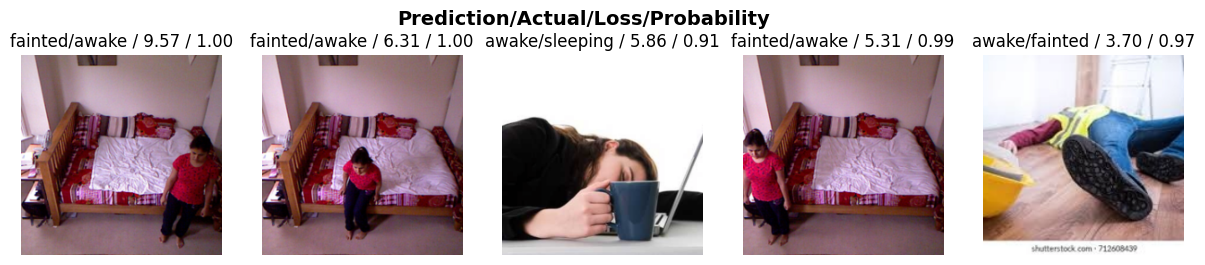

In [21]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)